In [1]:
from sklearn.preprocessing import StandardScaler
import neurobayes as nb
import gpax

import jax.random as jra

from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import numpy as np
import string

plt.style.use('seaborn-v0_8-bright')

myrcparams = {
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'legend.fontsize': 14,
    'legend.title_fontsize':20,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    #'figure.autolayout': True,
}
plt.rcParams.update(myrcparams)

import jax
jax.config.update("jax_enable_x64", True)

from acq import UCB, Thompson

In [2]:
N = 50 # defines density of design space grid 

## Read in data

In [3]:
df = pd.read_csv('history.csv', index_col=0).dropna()
df

,Cu,NaOH,median_ratio,fit_B,fit_A,fit_C
12,100.0,7.5,1.061765,0.863411,0.111075,1.540008
13,125.0,7.5,1.079406,0.913015,0.151946,1.614611
14,150.0,7.5,1.076986,0.823122,0.162740,1.802661
15,175.0,7.5,1.026320,1.000000,0.050074,1.877772
16,200.0,7.5,1.055157,0.917538,0.112666,1.877772
...,...,...,...,...,...,...
283,275.0,24.0,1.045752,1.543464,0.005812,0.586938
284,300.0,24.0,1.030849,1.519380,0.004675,0.529264
285,325.0,24.0,1.048951,1.822308,0.003292,0.659164
286,350.0,24.0,1.034483,1.774114,0.002309,0.520146


In [4]:
X = df[ ['Cu', 'NaOH'] ]
targets = {'median_ratio':'Median ratio', 'fit_A':r'$A_{fit}$', 'fit_B':r'$B_{fit}$', 'fit_C':r'$C_{fit}$'}
Y = df[ targets.keys() ]

## Train models

In [5]:
pbnn_net = nb.FlaxMLP(hidden_dims=[4, 4], target_dim=1)
rng_key_train, rng_key_predict = gpax.utils.get_keys()
model_name = 'pbnn'
model = nb.PartialBNN(pbnn_net, probabilistic_layer_names=['Dense0','Dense2'])

X_scaler, y_scaler = StandardScaler(), StandardScaler()

opts = [1.10, 'min', 'min', 'min']
results_dict = { target: {} for target in targets.keys() }

x = df.Cu.unique()
y = df.NaOH.unique()
X_grid = np.meshgrid( np.linspace(x.min(), x.max(), N), np.linspace(y.min(), y.max(), N) )
x_grid = X_grid[0]
y_grid = X_grid[1]
X_grid = np.vstack([X_grid[0].ravel(), X_grid[1].ravel()]).T

for i, (target, target_label) in enumerate(targets.items()):
    
    # Train
    X_scaler.fit(X)
    X_scaled = X_scaler.transform(X)
    X_grid_scaled = X_scaler.transform(X_grid)

    y = Y[target].to_numpy()
    y_scaler.fit(y.reshape(-1, 1))
    y_scaled = y_scaler.transform( y.reshape(-1, 1) ).reshape( y.shape )

    model.fit(X = X_scaled, y = y_scaled, num_warmup=1000, num_samples=1000, rng_key=rng_key_train) 

    # Predict on grid
    if model_name == 'bgp':
        y_pred_scaled, unc_pred_scaled  = model.predict(X_new=X_grid_scaled, n = 200, rng_key=rng_key_predict)
    else:
        y_pred_scaled, unc_pred_scaled  = model.predict(X_new=X_grid_scaled, rng_key=rng_key_predict)

    y_pred = y_scaler.inverse_transform( y_pred_scaled.reshape(-1,1) )

    if model_name == 'bgp':
        unc_pred_scaled =  unc_pred_scaled.std(axis=(0,1))
    unc_pred = y_scaler.inverse_transform( unc_pred_scaled.reshape(-1,1) ) 
    
    t_samples = Thompson(model=model, X=X_grid_scaled, y_scaler=y_scaler, opt=opts[i])
    
    results_dict[target]['y_pred'] = y_pred.reshape( (y_pred.shape[0],) )
    results_dict[target]['uncertainty'] = unc_pred.reshape( (unc_pred.shape[0],) )
    results_dict[target]['thompson'] = t_samples.reshape( (t_samples.shape[0],) )
    results_dict[target]['ucb'] = UCB( y_pred.reshape( (y_pred.shape[0],) ), unc_pred.reshape( (unc_pred.shape[0],) ), opt=opts[i]) 


/Users/alle927/miniconda3/envs/neq_rxt_scalarize/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Training deterministic NN...


Training Progress: 100%|██████████| 500/500 [00:00<00:00, 1086.83it/s, Epoch 500/500, LR: 0.010000, Loss: 0.3637 ]


Training partially Bayesian NN


sample: 100%|██████████| 2000/2000 [00:03<00:00, 520.72it/s, 127 steps of size 3.37e-02. acc. prob=0.92]
/Users/alle927/miniconda3/envs/neq_rxt_scalarize/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
sample: 100%|██████████| 2000/2000 [00:04<00:00, 454.69it/s, 255 steps of size 2.92e-02. acc. prob=0.94]
/Users/alle927/miniconda3/envs/neq_rxt_scalarize/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
sample: 100%|██████████| 2000/2000 [00:03<00:00, 556.63it/s, 191 steps of size 3.76e-02. acc. prob=0.91]
/Users/alle927/miniconda3/envs/neq_rxt_scalarize/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
sample: 100%|██████████| 2000/2000 [00:0

## Plot acquisition function values & selected experiments on design space grid

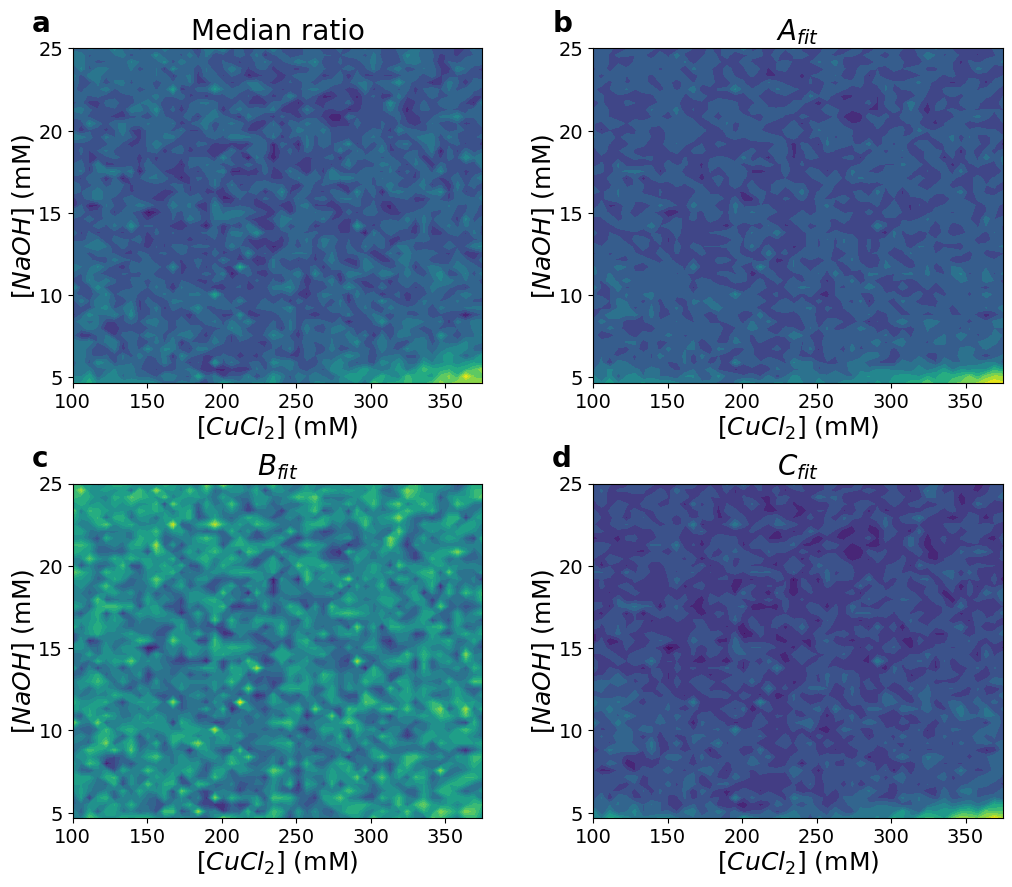

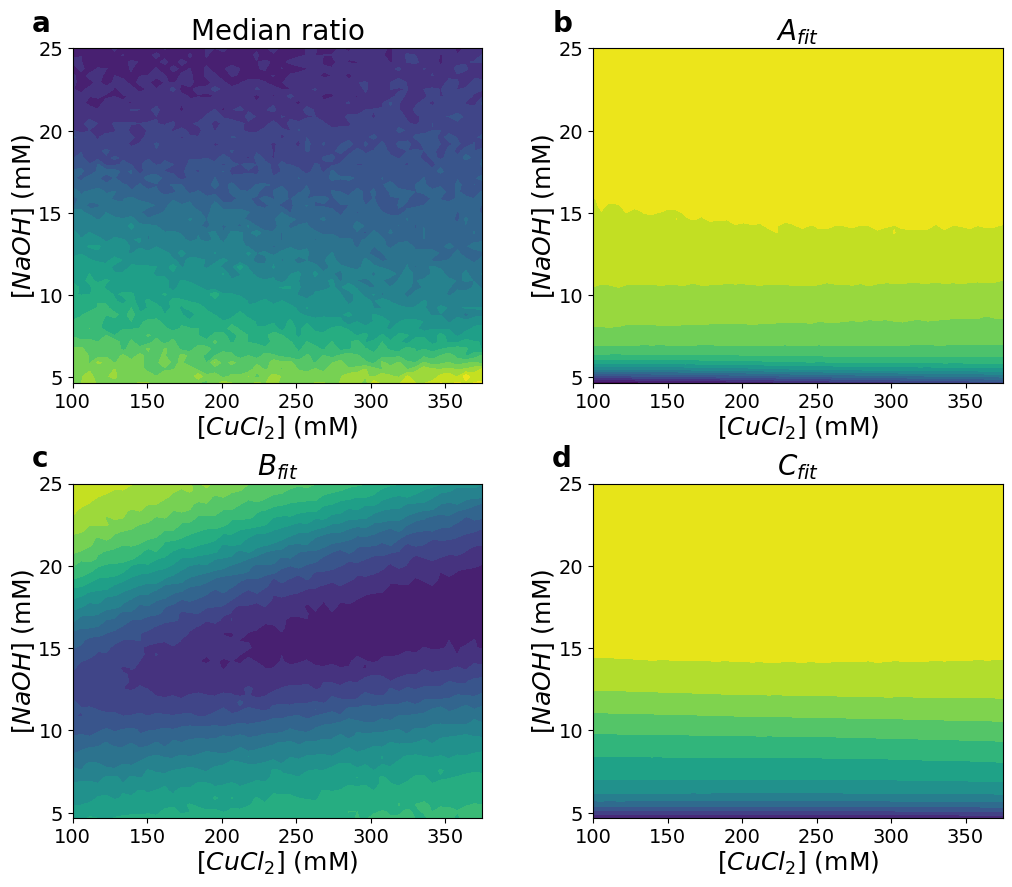

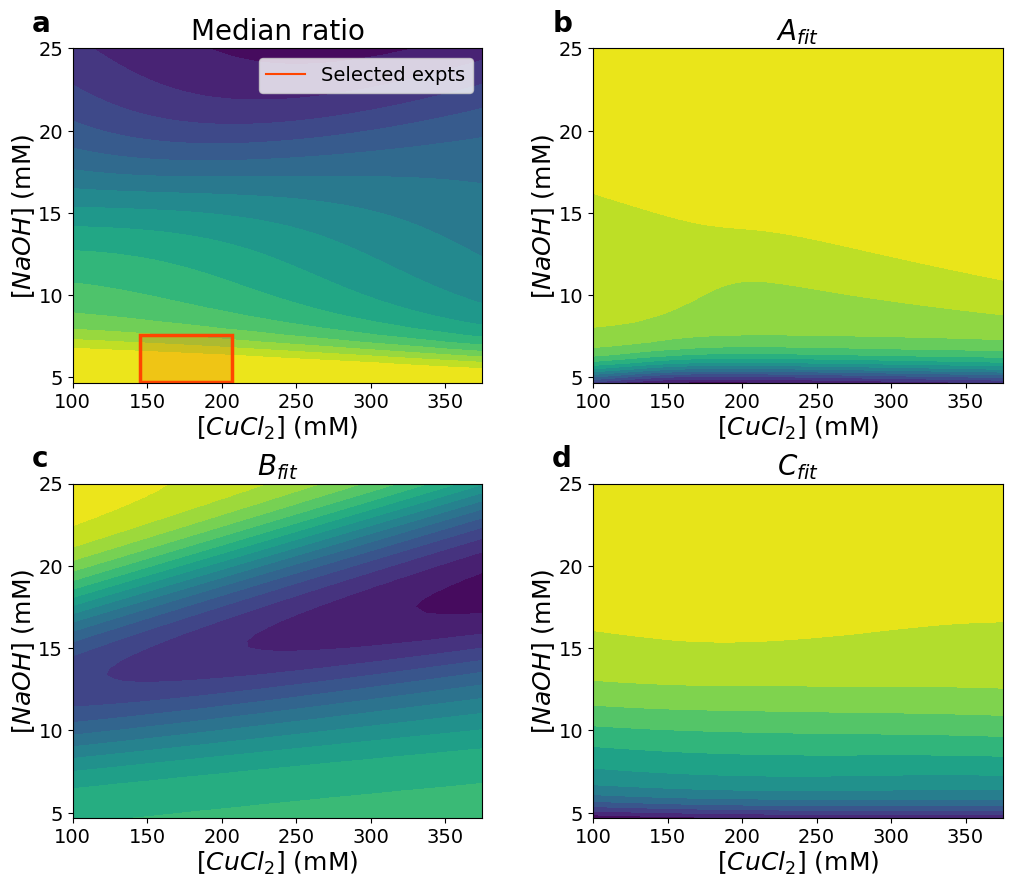

In [ ]:
acqs = {'uncertainty': '$\sigma_{pred}$', 'ucb': 'UCB', 'thompson': 'Thompson'}
for l, (acq, acq_label) in enumerate(acqs.items()):

    fig,axes = plt.subplots(2, 2, figsize=(12.0, 10.0))

    x = df.Cu.unique()
    y = df.NaOH.unique()
    X_grid = np.meshgrid( np.linspace(x.min(), x.max(), N), np.linspace(y.min(), y.max(), N) )
    x_grid = X_grid[0]
    y_grid = X_grid[1]
    X_grid = np.vstack([X_grid[0].ravel(), X_grid[1].ravel()]).T
            
    for i, (target, target_label) in enumerate(targets.items()):
        
        acq_vals = results_dict[target][acq]
        z_grid_acq = acq_vals.reshape((N, N))
        axes[i//2, i%2].contourf( x_grid, y_grid, z_grid_acq, levels=15, cmap='viridis')
            
        if target == 'median_ratio' and acq == 'thompson':
            acq_df = pd.DataFrame( np.column_stack( (X_grid[:,0], X_grid[:,1], acq_vals) ), columns = ['CuCl2', 'NaOH', 'Acq'] )
            acq_df_sorted = acq_df.sort_values(by='Acq', ascending=False)

            new_NaOH, new_CuCl2 = [], []
            for index, row in acq_df_sorted.iterrows():
                this_CuCl2 = round(row.CuCl2,1)
                this_NaOH = round(row.NaOH,1)
                if len(new_NaOH) < 8 and this_NaOH not in new_NaOH:
                    new_NaOH.append(this_NaOH)
                if len(new_CuCl2) < 12 and this_CuCl2 not in new_CuCl2:
                    new_CuCl2.append(this_CuCl2)
            
            new_grid = np.meshgrid( sorted(new_CuCl2), sorted(new_NaOH) )
            new_grid = np.vstack([new_grid[0].ravel(), new_grid[1].ravel()]).T

            new_X = pd.DataFrame(new_grid, columns=['CuCl2', 'NaOH'])

            x = new_X['CuCl2'].min()
            y = new_X['NaOH'].min()
            width = new_X['CuCl2'].max() - x
            height = new_X['NaOH'].max() - y
            rect1 = patches.Rectangle((x, y), width, height, facecolor="None", edgecolor="orangered", linewidth=2.5)
            rect2 = patches.Rectangle((x, y), width, height, facecolor="orangered", edgecolor="None", alpha=0.2)
            axes[i//2, i%2].add_patch(rect1)
            axes[i//2, i%2].add_patch(rect2)
            proxy_rect = Line2D([0], [0], linestyle='-', color='orangered')
            axes[i//2, i%2].legend([proxy_rect], ['Selected expts'], framealpha=0.8)

        axes[i//2, i%2].set_xlabel('[$CuCl_2$] (mM)')
        axes[i//2, i%2].set_ylabel('[$NaOH$] (mM)')
        axes[i//2, i%2].set_title(f'{target_label}', fontsize=20)
        axes[i//2, i%2].xaxis.labelpad = 2
        axes[i//2, i%2].yaxis.labelpad = 1
        axes[i//2, i%2].text(-0.1, 1.05, f'{string.ascii_lowercase[i]}', transform=axes[i//2, i%2].transAxes, size=20, fontweight='bold')

    fig.subplots_adjust(hspace=0.3, wspace=0.27)
    fig.savefig(f"{acq}_map_pbnn_rectangles.png", dpi=600)

## Colorbars

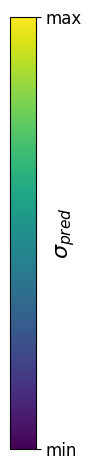

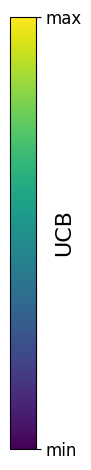

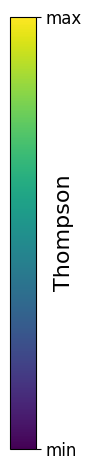

In [7]:
for l, (acq, acq_label) in enumerate(acqs.items()):
    fig,ax = plt.subplots()
    arr = np.array([[0.0, 1.0]])
    img = ax.imshow(arr, cmap='viridis')
    ax.set_visible(False)
    cax = plt.axes([0.05, 0.05, 0.04, 0.9])
    cbar = fig.colorbar(img, cax=cax)
    cbar.ax.set_yticks([0.0, 1.0], labels=['min', 'max'])
    cbar.ax.tick_params(labelsize=12) 
    cbar.set_label(acq_label, fontsize=16, labelpad=-20)
    fig.savefig(f'{acq}_cbar.png', dpi=600)